In [ ]:
# ==========================================
# STEP 1.1: INSTALL LIBRARIES
# ==========================================
# Install Diffusers for Stable Diffusion and generic training tools
!pip install -q -U diffusers transformers accelerate peft bitsandbytes
!pip install -q -U git+https://github.com/huggingface/diffusers.git

import os
import shutil
import json
import pandas as pd
from tqdm.notebook import tqdm

# Setup Paths
INPUT_IMGS = "/kaggle/input/fashion-product-images-small/images"
INPUT_CSV = "/kaggle/input/fashion-product-images-small/styles.csv"
TRAIN_DIR = "/kaggle/working/eco_dataset"
OUTPUT_LORA = "/kaggle/working/eco_fashion_lora"

# Cleanup from previous runs
if os.path.exists(TRAIN_DIR): shutil.rmtree(TRAIN_DIR)
os.makedirs(TRAIN_DIR, exist_ok=True)

In [ ]:
# ==========================================
# STEP 1.2: PREPARE DATA (FILTERING)
# ==========================================
print("⚙️ Building the Eco-Fashion Dataset...")

# 1. Load the CSV
df = pd.read_csv(INPUT_CSV, on_bad_lines='skip')

# 2. Filter for Sustainable Materials
# We look for "Cotton", "Linen", "Silk", "Wool" in the name
eco_keywords = ['Cotton', 'Linen', 'Wool', 'Silk', 'Viscose', 'Bamboo']
pattern = '|'.join(eco_keywords)
eco_df = df[df['productDisplayName'].str.contains(pattern, case=False, na=False)]

# Limit to 400 images to keep training fast (increase to 1000+ for better results)
eco_df = eco_df.head(400)

metadata = []

# 3. Copy Images & Write Captions
for idx, row in tqdm(eco_df.iterrows(), total=len(eco_df)):
    img_name = str(row['id']) + ".jpg"
    src = os.path.join(INPUT_IMGS, img_name)
    dst = os.path.join(TRAIN_DIR, img_name)
    
    if os.path.exists(src):
        shutil.copy(src, dst)
        
        # Find which material matched
        mat = next((k for k in eco_keywords if k.lower() in row['productDisplayName'].lower()), "Sustainable")
        
        # TRIGGER WORD: "sks"
        # We teach the model that "sks" means "This specific high-quality eco texture"
        prompt = f"a photo of sks {mat} clothing, {row['articleType']}, high quality texture, sustainable fashion"
        
        metadata.append({"file_name": img_name, "text": prompt})

# 4. Save Metadata
with open(f"{TRAIN_DIR}/metadata.jsonl", "w") as f:
    for entry in metadata:
        json.dump(entry, f)
        f.write('\n')

print(f"✅ Training Data Ready: {len(metadata)} images prepared.")

In [ ]:
# ==========================================
# STEP 1.3: TRAIN THE MODEL (FIXED)
# ==========================================
# Download training script
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

print("🚀 Starting Training... (This will take ~20 mins)")

# FIX: Added --mixed_precision="fp16" to the SCRIPT arguments as well
!accelerate launch --mixed_precision="fp16" train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir=$TRAIN_DIR \
  --dataloader_num_workers=2 \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=600 \
  --learning_rate=1e-04 \
  --lr_scheduler="cosine" \
  --mixed_precision="fp16" \
  --output_dir=$OUTPUT_LORA \
  --seed=42

print("🎉 TRAINING COMPLETE! LoRA weights saved.")

In [ ]:
# ==========================================
# STEP 2.1: INSTALL STYLEGAN
# ==========================================
import sys
import torch
import pickle
import numpy as np
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline

# Clone StyleGAN2-ADA repo if not present
if not os.path.isdir("/kaggle/working/stylegan2-ada-pytorch"):
    !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /kaggle/working/stylegan2-ada-pytorch

sys.path.insert(0, "/kaggle/working/stylegan2-ada-pytorch")

print("✅ Fusion Environment Ready.")

🎨 Loading Stable Diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

   ⚠️ LoRA not found. Results won't have eco-texture.

🚀 STARTING CLEAN GENERATION (4 variations each)...

🧵 Designing: a dress made of woven recycled blue plastic strips


  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_1_v1.png


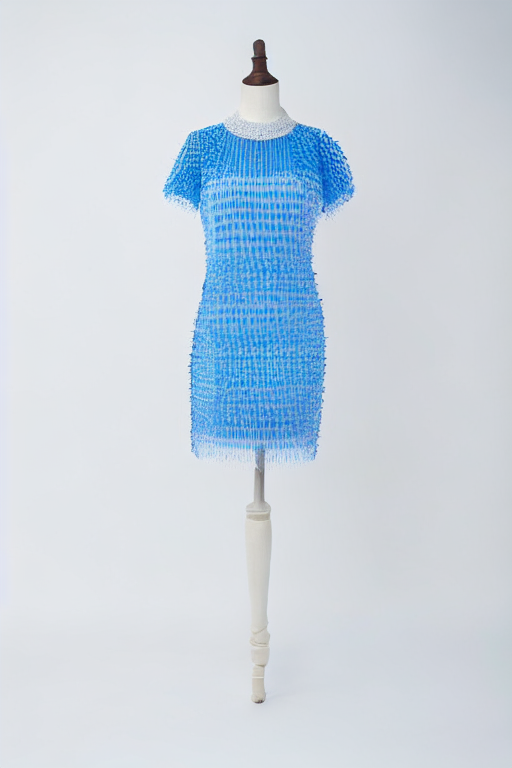

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_1_v2.png


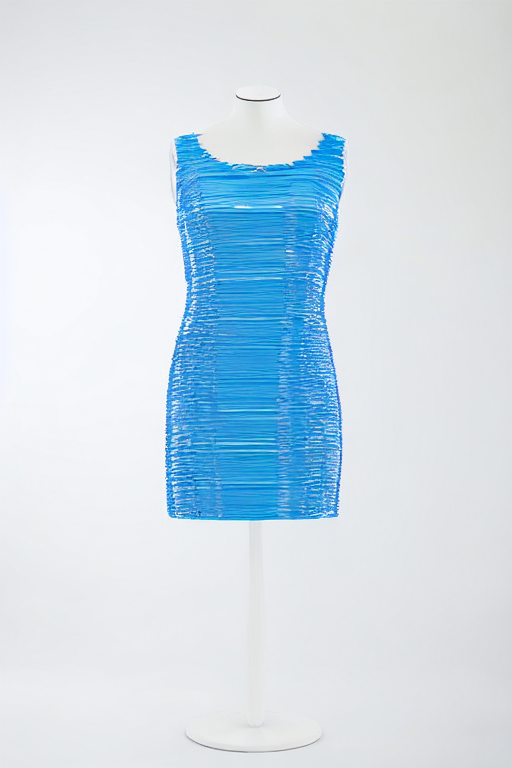

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_1_v3.png


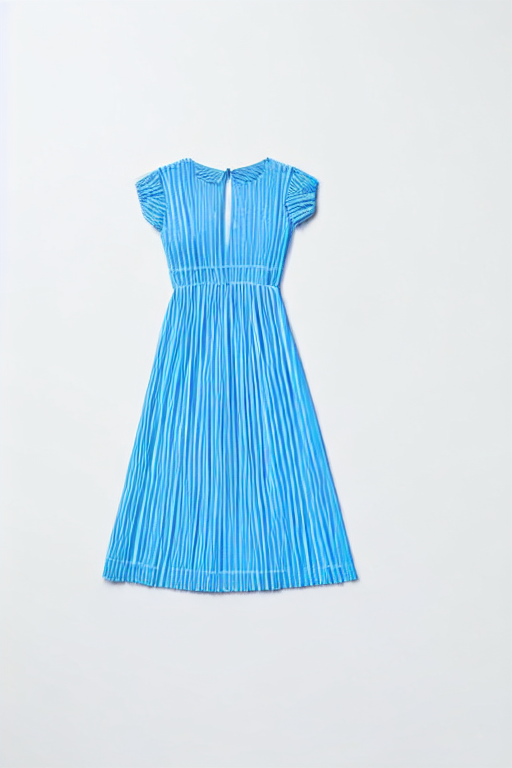

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_1_v4.png


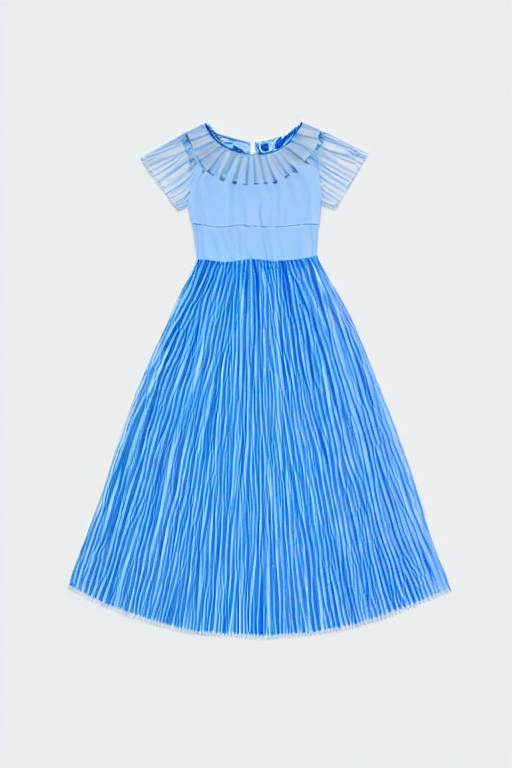

--------------------------------------------------
🧵 Designing: a tailored suit jacket made of raw organic beige linen


  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_2_v1.png


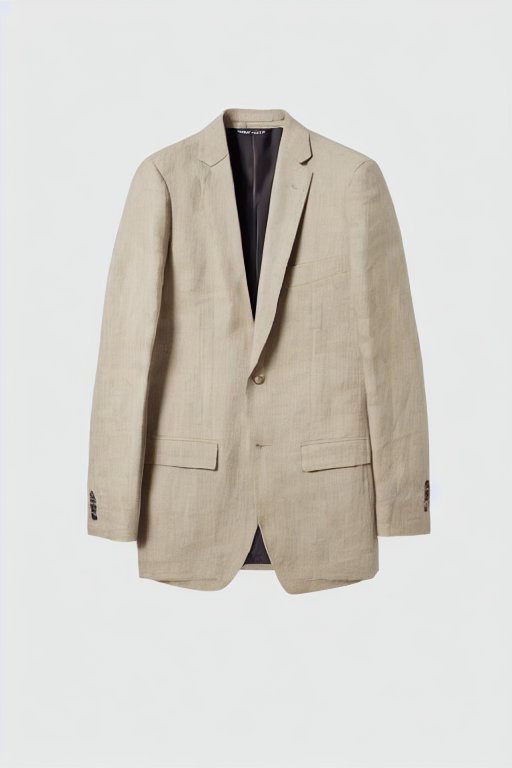

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_2_v2.png


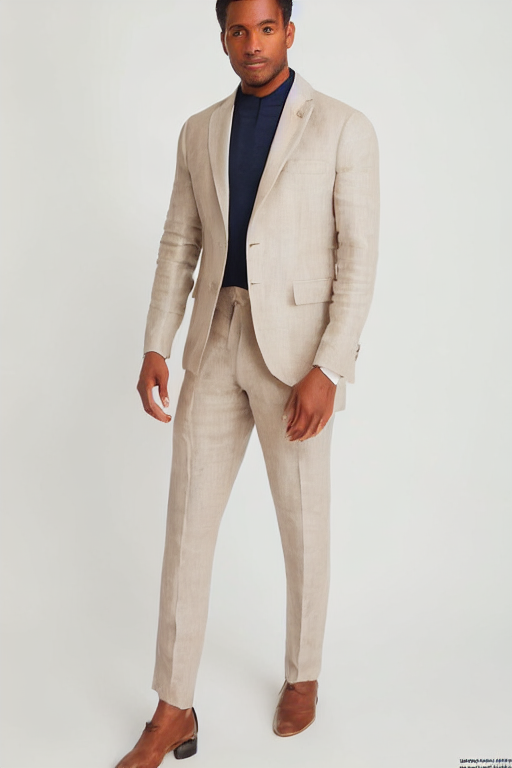

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_2_v3.png


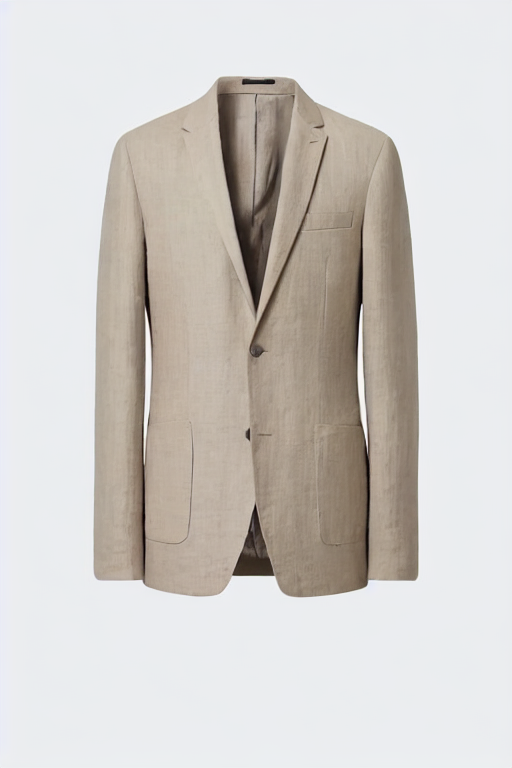

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_2_v4.png


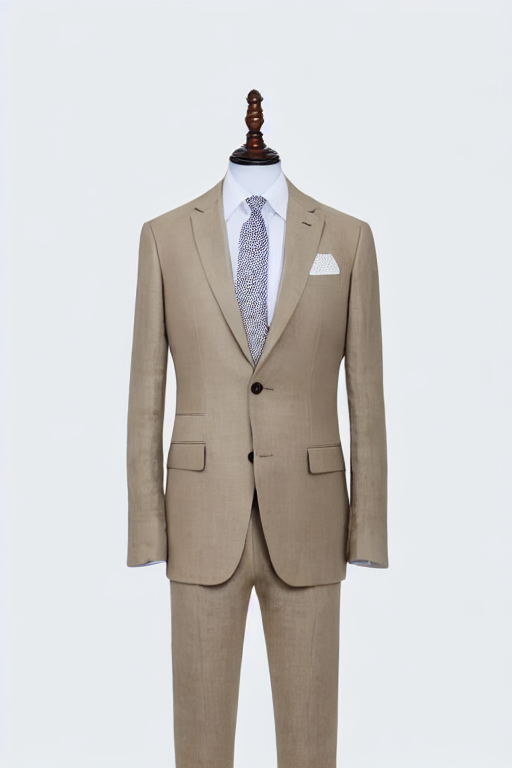

--------------------------------------------------
🧵 Designing: an oversized coat made of rough hemp fabric


  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_3_v1.png


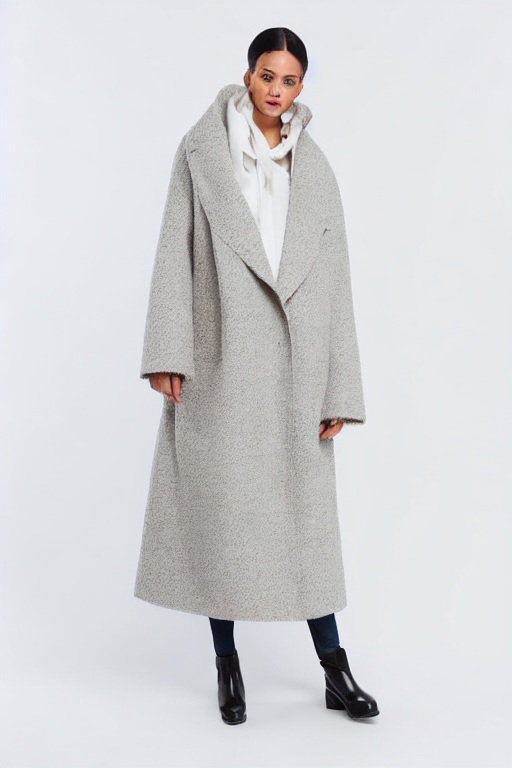

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_3_v2.png


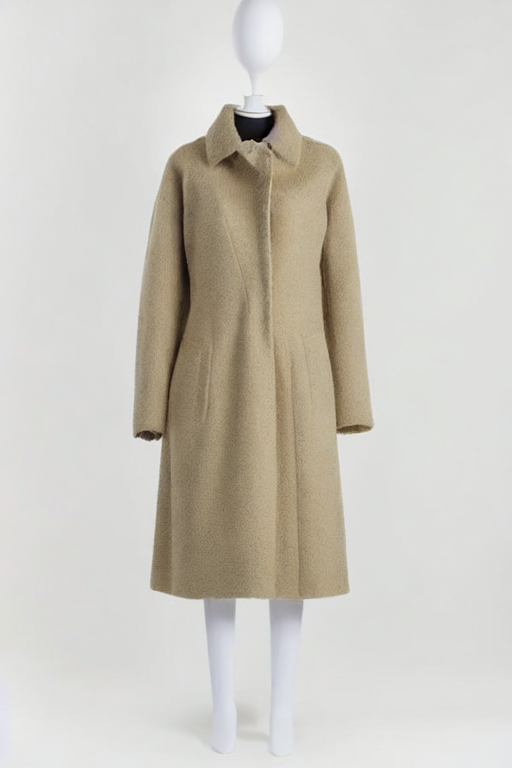

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_3_v3.png


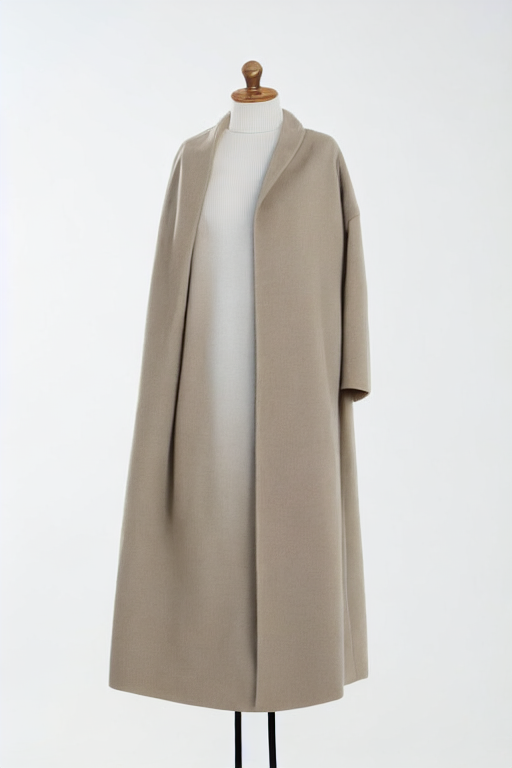

  0%|          | 0/49 [00:00<?, ?it/s]

   Saved: clean_3_v4.png


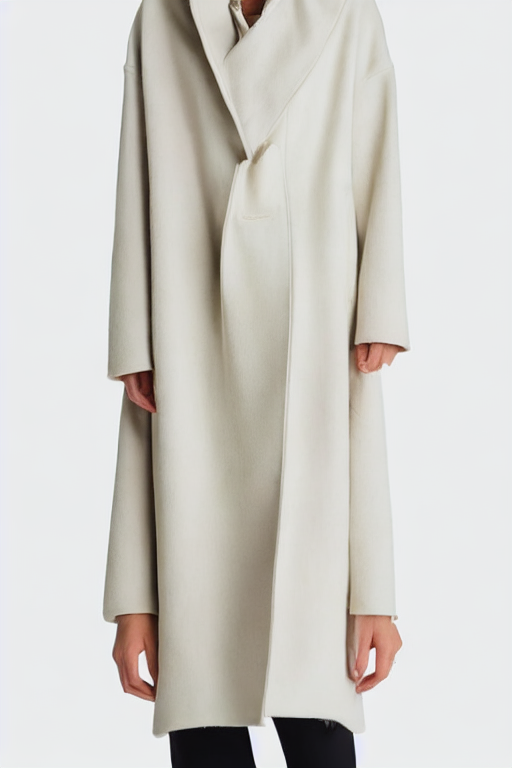

--------------------------------------------------

🎉 DONE! Check the 'final_fashion' folder output.


In [14]:
# ==========================================
# FINAL SOLUTION: CLEAN GHOST MANNEQUIN ENGINE
# ==========================================
import sys
import os
import torch
import numpy as np
from PIL import Image, ImageOps, ImageDraw
from IPython.display import display
from diffusers import StableDiffusionImg2ImgPipeline

# 1. SETUP (No StyleGAN needed anymore!)
os.makedirs("/kaggle/working/final_fashion", exist_ok=True)

class EcoFusionEngine:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.lora_path = "/kaggle/working/eco_fashion_lora" 
        
        # LOAD STABLE DIFFUSION (The Texture Artist)
        print("🎨 Loading Stable Diffusion...")
        self.pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float16
        ).to(self.device)
        self.pipe.safety_checker = None
        
        if os.path.exists(self.lora_path):
            self.pipe.load_lora_weights(self.lora_path, weight_name="pytorch_lora_weights.safetensors")
            print("   ✅ Custom Eco-Texture LoRA Active.")
        else:
             print("   ⚠️ LoRA not found. Results won't have eco-texture.")

    def create_base_sketch(self, width, height):
        # Create a clean grey background
        base = Image.new('RGB', (width, height), color=(220, 220, 220))
        
        # Draw a simple, lighter vertical rectangle in the middle
        # This suggests a "body shape" without a head
        draw = ImageDraw.Draw(base)
        margin_x = width // 4
        margin_y_top = height // 5  # Start lower down (no head area)
        margin_y_bottom = height // 10
        
        draw.rectangle(
            [(margin_x, margin_y_top), (width - margin_x, height - margin_y_bottom)],
            fill=(180, 180, 180), # Slightly darker grey suggesting an object
            outline=None
        )
        
        # Blur it slightly so it's just a soft suggestion of shape
        from PIL import ImageFilter
        base = base.filter(ImageFilter.GaussianBlur(radius=20))
        
        return base

    def generate(self, prompt, seed):
        # 1. Create a CLEAN Input Sketch (No chaotic noise)
        sketch = self.create_base_sketch(512, 768)
        
        # 2. Fusion (Strict Ghost Mannequin Prompts)
        
        # POSITIVE: Forces "Invisible Mannequin" product photography
        full_prompt = (
            f"a professional product photograph of {prompt}, "
            "ghost mannequin style, hollow clothes, invisible model, "
            "neck down shot, centered, studio lighting, clean white background, 8k, highly detailed texture"
        )
        
        # NEGATIVE: BANS HUMANS COMPLETELY
        neg_prompt = (
            "human, person, head, face, eyes, hair, skin, hands, feet, model, "
            "mannequin stand, visible support, hanger, "
            "ugly, blurry, distorted, low quality, messy background"
        )
        
        # Set seed for reproducibility
        generator = torch.Generator(device=self.device).manual_seed(seed)
        
        final_image = self.pipe(
            prompt=full_prompt,
            negative_prompt=neg_prompt,
            image=sketch, 
            strength=0.98, # High strength: ignore the grey blob, follow the prompt exactly
            guidance_scale=10.0, # Very high guidance: obey "no human" rule strictly
            num_inference_steps=50,
            generator=generator
        ).images[0]
        
        return final_image

# 3. RUN IT (Generate 4 options for each)
engine = EcoFusionEngine()

prompts = [
    "a dress made of woven recycled blue plastic strips",
    "a tailored suit jacket made of raw organic beige linen",
    "an oversized coat made of rough hemp fabric"
]

print("\n🚀 STARTING CLEAN GENERATION (4 variations each)...\n")

for i, p in enumerate(prompts):
    print(f"🧵 Designing: {p}")
    for v in range(4): # Generate 4 versions to pick from
        current_seed = 8000 + (i*100) + v
        result = engine.generate(p, seed=current_seed)
        
        filename = f"clean_{i+1}_v{v+1}.png"
        save_path = f"/kaggle/working/final_fashion/{filename}"
        result.save(save_path)
        
        print(f"   Saved: {filename}")
        display(result)
    print("-" * 50)

print("\n🎉 DONE! Check the 'final_fashion' folder output.")